In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Settings

In [3]:
%cd /content/drive/MyDrive/Parkinson

/content/drive/MyDrive/Parkinson


In [41]:
import os
import glob

import pandas as pd
import numpy as np
from PIL import Image

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 39개 마커
MARKERS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'LSHO', 'RSHO', 'CLAV', 'RBAK',
           'LUPA', 'RUPA', 'STRN', 'T10', 'LELB', 'RELB', 'LFRM', 'RFRM',
           'LWRA', 'RWRA', 'LWRB', 'RWRB', 'LFIN', 'RFIN', 'LASI', 'RASI',
           'LPSI', 'RPSI', 'LTHI', 'RTHI', 'LKNE', 'RKNE', 'LTIB', 'RTIB',
           'LANK', 'RANK', 'LTOE', 'RTOE', 'LHEE', 'RHEE']

39

In [6]:
DATAPATH = "./dataset"
CONTROL = os.path.join(DATAPATH, "Controls")
PD = os.path.join(DATAPATH, "PD")

In [34]:
# Save as Image
IMGPATH = DATAPATH + "_img"
IMG_CONTROL = os.path.join(IMGPATH, 'Controls')
IMG_PD = os.path.join(IMGPATH, 'PD')

if not os.path.exists(IMGPATH):
    os.mkdir(IMGPATH)
if not os.path.exists(IMG_CONTROL):
    os.mkdir(IMG_CONTROL)
if not os.path.exists(IMG_PD):
    os.mkdir(IMG_PD)

# Save as Numpy array
NPPATH = DATAPATH + "_np"
NP_CONTROL = os.path.join(NPPATH, 'Controls')
NP_PD = os.path.join(NPPATH, 'PD')

if not os.path.exists(NPPATH):
    os.mkdir(NPPATH)
if not os.path.exists(NP_CONTROL):
    os.mkdir(NP_CONTROL)
if not os.path.exists(NP_PD):
    os.mkdir(NP_PD)

## Data Loading

In [22]:
df_csv = pd.read_csv("csvinfo.csv")
df_csv

,path,category,name,trial,frame length,remove,LFHD,RFHD,LBHD,RBHD,...,LKNE,RKNE,LTIB,RTIB,LANK,RANK,LTOE,RTOE,LHEE,RHEE
0,./dataset/Controls/PREP_BHY_BW1.csv,Controls,BHY,BW1,565,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,./dataset/Controls/PREP_BHY_BW2.csv,Controls,BHY,BW2,472,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,./dataset/Controls/PREP_BHY_BW3.csv,Controls,BHY,BW3,486,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,./dataset/Controls/PREP_CHH_BW1.csv,Controls,CHH,BW1,808,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,./dataset/Controls/PREP_CHH_BW2.csv,Controls,CHH,BW2,801,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,./dataset/PD/PREP_YSC_FW2.csv,PD,YSC,FW2,228,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
604,./dataset/PD/PREP_YSC_FW3.csv,PD,YSC,FW3,237,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354:356
605,./dataset/PD/PREP_YYS_FW1.csv,PD,YYS,FW1,279,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,./dataset/PD/PREP_YYS_FW2.csv,PD,YYS,FW2,258,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df = df_csv.loc[df_csv['remove']==False, :]

print(f"Raw data : {len(df_csv)}")
print(f"To remove:  {df_csv['remove'].values.sum()}") # 결측값이 많아서 제외
print(f"Remaining: {len(df)}")

Raw data : 608
To remove:  49
Remaining: 559


In [17]:
df['category'].value_counts()

PD          427
Controls    132
Name: category, dtype: int64

In [18]:
df['category'].value_counts(normalize=True)

PD          0.763864
Controls    0.236136
Name: category, dtype: float64

## csv2npy & csv2image

In [35]:
frame_len = defaultdict()

for i, path in enumerate(df['path']):
    df_i = pd.read_csv(path)
    category, filename = path.split('/')[2:]
    name, trial = filename[:-4].split('_')[1:]
    
    # NULL인 행 제거해야 함!!!
    df_full = df_i.dropna()
    frame_len[f'{category}_{name}_{trial}'] = len(df_full)

    # Split X,Y,Z
    df_x = df_full.filter(regex='X')
    df_y = df_full.filter(regex='Y')
    df_z = df_full.filter(regex='Z')

    # Reshape to 3D Tensor
    df_img = np.stack([df_x, df_y, df_z], -1)

    # Save as Numpy array
    SAVENPPATH = NP_PD if category == 'PD' else NP_CONTROL
    np.save(os.path.join(SAVENPPATH, f"NP_{name}_{trial}.npy"), df_img)

    # Save as Image
    SAVEIMGPATH = IMG_PD if category == 'PD' else IMG_CONTROL
    df_img_jpg = Image.fromarray(df_img.astype(np.uint8)) # Numpy array -> PIL image
    df_img_jpg.save(os.path.join(SAVEIMGPATH, f"IMG_{name}_{trial}.jpg"))
    

In [39]:
frame_len_sorted = sorted(frame_len.items(), key=lambda x: x[1])
print(f"Minimum frame length: {frame_len_sorted[0]}")
print(f"Maximum frame length: {frame_len_sorted[-1]}")

Minimum frame length: ('PD_JWS_FW3', 179)
Maximum frame length: ('PD_BSB_BW2', 1899)


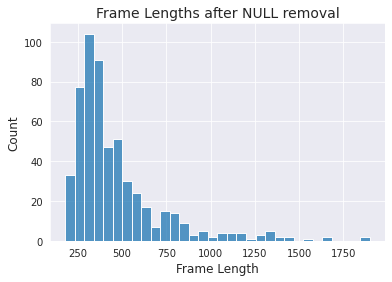

In [51]:
sns.set_style('darkgrid')
fig = sns.histplot(x=frame_len.values())
fig.set_xlabel('Frame Length', fontsize=12)
fig.set_ylabel('Count', fontsize=12)
fig.set_title('Frame Lengths after NULL removal', fontsize=14)
plt.show()